# Pipeline draft

In [148]:
import torch
import numpy as np
from omegaconf import OmegaConf
from functools import partial
import gymnasium as gym
import matplotlib.pyplot as plt

import bbrl_utils
from bbrl_utils.notebook import setup_tensorboard
from bbrl.stats import WelchTTest
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl.agents.gymnasium import ParallelGymAgent, make_env
from bbrl.workspace import Workspace
from bbrl.utils.replay_buffer import ReplayBuffer

import bbrl_gymnasium

from pmind.algorithms import DQN, DDPG, TD3, OfflineTD3
from pmind.losses import dqn_compute_critic_loss, ddqn_compute_critic_loss
from pmind.training import run_dqn, run_ddpg, run_td3, run_td3_offline
from pmind.replay import (collect_policy_transitions, 
                          collect_uniform_transitions, 
                          mix_transitions, 
                          test_rb_compositions)

from pmind.config.loader import load_config

bbrl_utils.setup()

cfg = load_config("bbrl_example")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# setup_tensorboard("./outputs/tblogs")

# Obtain transitions

In [134]:
ENV_NAME = ["CartPoleContinuous-v1","Pendulum-v1","MountainCarContinuous-v0","LunarLanderContinuous-v3"][0]
BUFFER_SIZE = 100_000
PROPORTIONS = np.linspace(0,1,10)

## Best policy

Get the best policy and get transitions with it

In [135]:
cfg_td3_best = OmegaConf.create(cfg.td3)
cfg_td3_best.gym_env.env_name = ENV_NAME

# accelerate for the sake of test:
cfg_td3_best.algorithm.max_epochs = 11_000
cfg_td3_best.algorithm.learning_starts = 1000

# playing with parameters for mountain car:
# cfg_td3_best.algorithm.action_noise = 0.3
# cfg_td3_best.algorithm.discount_factor = 0.995
# cfg_td3_best.actor_optimizer.lr = 1e-4
# cfg_td3_best.critic_optimizer.lr = 1e-3
# cfg_td3_best.algorithm.tau_target = 0.005

cfg_td3_best.plot_agents=False # TODO: plot_agents() doesn't work with Lunar Lander

td3 = TD3(cfg_td3_best)
run_td3(td3)
td3.visualize_best()
best_policy_agent = td3.best_policy

  0%|          | 0/11000 [00:00<?, ?it/s]

Video of best agent recorded in folder outputs/CartPoleContinuous-v1/td3-S1_20260214-214301/best_agent
moviepy is not installed, skipping video display


In [136]:
rb_best = collect_policy_transitions(best_policy_agent ,ENV_NAME, buffer_size=BUFFER_SIZE)
print(f"Replay buffer with {rb_best.size()} transitions")

Replay buffer with 100000 transitions


## Uniform exploration

In [137]:
rb_unif = collect_uniform_transitions(ENV_NAME, buffer_size=BUFFER_SIZE)
print(f"Replay buffer with {rb_unif.size()} transitions")

100%|██████████| 100000/100000 [00:06<00:00, 14346.79it/s]

Replay buffer with 100000 transitions


# Offline learning on mixed replay buffer

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

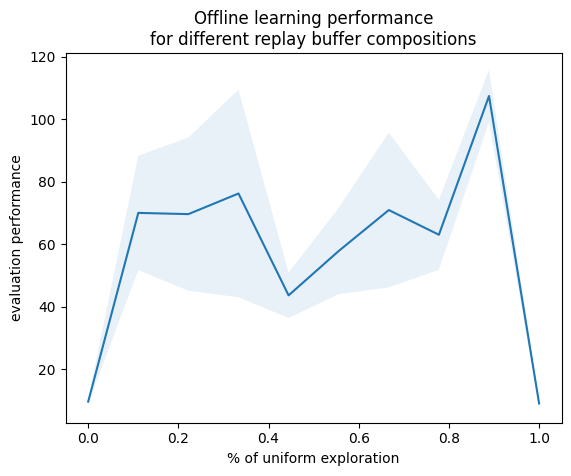

In [150]:
cfg_td3_offline = OmegaConf.create(cfg.td3)
cfg_td3_offline.gym_env.env_name = ENV_NAME

# accelerate for the sake of test:
cfg_td3_offline.algorithm.n_steps = 100
cfg_td3_offline.algorithm.max_epochs = 1000

# we don't care about when learning starts for offline:
cfg_td3_offline.algorithm.learning_starts = None

# there is no exploration in off-line learning 
cfg_td3_offline.algorithm.action_noise = None
cfg_td3_offline.algorithm.target_policy_noise = None

cfg_td3_offline.plot_agents=False # TODO: plot_agents() doesn't work with Lunar Lander


perfs = test_rb_compositions(rb_unif=rb_unif, 
                    rb_best=rb_best,
                    buffer_size=BUFFER_SIZE,
                    proportions=PROPORTIONS,
                    agent_constructor=OfflineTD3,
                    cfg= cfg_td3_offline,
                    offline_run=run_td3_offline)